# Preparando a Base

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


pd.options.mode.chained_assignment = None
df_raw = pd.read_csv('/content/kc_house_data.csv')

# separa duas Bases: 2014 e 2015
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw['year'] = df_raw['date'].dt.year
df_raw_2014 = df_raw[ df_raw['year'] == 2014]
df_raw_2015 = df_raw[ df_raw['year'] == 2015]

df_raw_2014 = df_raw_2014.drop(columns='year')
df_raw_2015 = df_raw_2015.drop(columns='year')

len(df_raw_2014),  len(df_raw_2015)

RANDOM_STATE = 4755
np.random.seed(RANDOM_STATE)

In [ ]:
#demais features
data14 = df_raw_2014.iloc[:, 3:].copy()
data15 = df_raw_2015.iloc[:, 3:].copy()

data14 =data14.drop(columns= ['zipcode', 'lat', 'long'])
data15 =data15.drop(columns= ['zipcode', 'lat', 'long'])

#--> preco
y14 = df_raw_2014.iloc[:, 2].copy()
y15 = df_raw_2015.iloc[:, 2].copy()

# visualizar a base: data14 e data15

CONDITION:

1 → Muito ruim (casa em péssimo estado, precisa de reformas urgentes)

2 → Ruim (problemas estruturais ou de manutenção evidentes)

3 → Média (condição típica para a idade do imóvel, habitável, mas com sinais de desgaste)

4 → Boa (bem mantida, poucos reparos necessários)

5 → Excelente (estado impecável, como novo ou recém-reformado)

In [ ]:
data14

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0             3       1.00         1180      5650     1.0           0     0   
1             3       2.25         2570      7242     2.0           0     0   
3             4       3.00         1960      5000     1.0           0     0   
5             4       4.50         5420    101930     1.0           0     0   
6             3       2.25         1715      6819     2.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21603         3       2.50         2270      5536     2.0           0     0   
21605         4       2.50         2520      6023     2.0           0     0   
21608         3       2.50         1530      1131     3.0           0     0   
21610         2       0.75         1020      1350     2.0           0     0   
21612         2       0.75         1020      1076     2.0           0     0   

       condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0              3      7        1180              0      1955             0   
1              3      7        2170            400      1951          1991   
3              5      7        1050            910      1965             0   
5              3     11        3890           1530      2001             0   
6              3      7        1715              0      1995             0   
...          ...    ...         ...            ...       ...           ...   
21603          3      8        2270              0      2003             0   
21605          3      9        2520              0      2014             0   
21608          3      8        1530              0      2009             0   
21610          3      7        1020              0      2009             0   
21612          3      7        1020              0      2008             0   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
3               1360        5000  
5               4760      101930  
6               2238        6819  
...              ...         ...  
21603           2270        5731  
21605           2520        6023  
21608           1530        1509  
21610           1020        2007  
21612           1020        1357  

[14633 rows x 15 columns]

<Axes: >

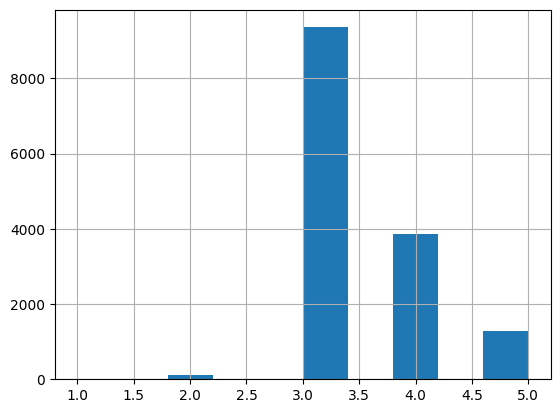

In [ ]:
data14['condition'].hist()

VIEW:

0 → Sem vista especial ou relevante.

1 → Vista ruim ou pouco atrativa.

2 → Vista média (melhor que nada, mas não impressiona).

3 → Boa vista (ex.: lago, montanha ou área verde agradável).

4 → Vista excelente/panorâmica (alto valor estético e valorização).

<Axes: >

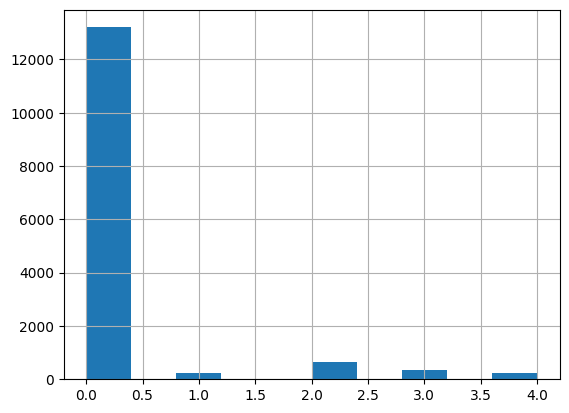

In [ ]:
data14['view'].hist()

WATER:

0 → Não é à beira d’água.

1 → É à beira d’água (possui acesso ou vista direta para o corpo d’água).

<Axes: >

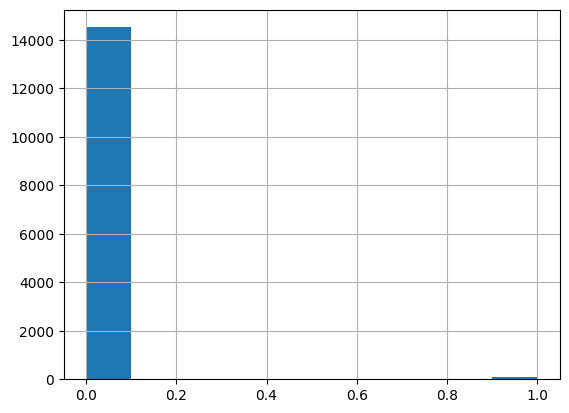

In [ ]:
data14['waterfront'].hist()

1 a 3: Muito abaixo do padrão (qualidade baixa, construção simples ou antiga, acabamento ruim)

4 a 6: Padrão abaixo da média (construção mais simples, menos recursos)

7 a 8: Padrão médio (construção normal para a região, acabamento razoável)

9 a 10: Padrão acima da média (boa qualidade, materiais melhores, design mais elaborado)

11 a 13: Alto padrão (construção de luxo, acabamento premium, detalhes arquitetônicos sofisticados)

<Axes: >

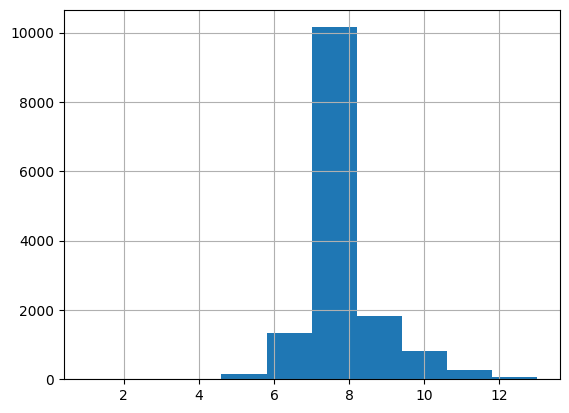

In [ ]:
data14['grade'].hist()

y14

(array([7.537e+03, 5.388e+03, 1.079e+03, 3.490e+02, 1.390e+02, 5.200e+01,
        3.900e+01, 2.200e+01, 1.200e+01, 7.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([  78000.,  459100.,  840200., 1221300., 1602400., 1983500.,
        2364600., 2745700., 3126800., 3507900., 3889000., 4270100.,
        4651200., 5032300., 5413400., 5794500., 6175600., 6556700.,
        6937800., 7318900., 7700000.]),
 <BarContainer object of 20 artists>)

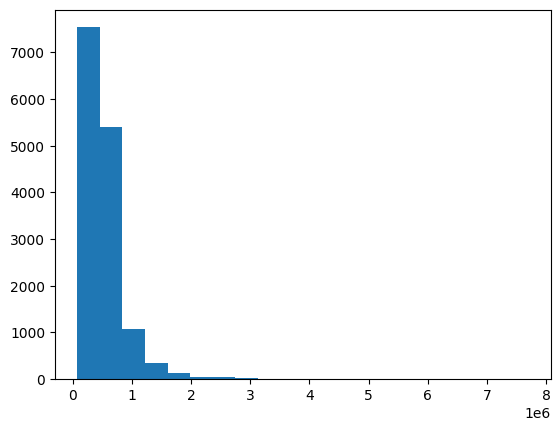

In [ ]:
plt.hist(y14,bins=20)

# visualizar

In [ ]:
# --- Visualization: annual returns ---
def plot_returns_histogram(y, year):
    plt.figure(figsize=(8, 5))
    min_val = np.floor(y.min() * 20) / 20
    max_val = np.ceil(y.max() * 20) / 208
    num_bins = int((max_val - min_val) * 20)
    if num_bins <= 0: num_bins = 10
    plt.hist(y, bins=num_bins, density=True, alpha=0.7, label='Returns Distribution')

    plt.xlim(-1, 4)
    plt.title(f'{year} Returns Histogram')
    plt.xlabel("Returns")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_returns_histogram(y14, 2014)
plot_returns_histogram(y15, 2015)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ecb7c6fa8e0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ecb7c6f82c0> (for post_execute):


KeyboardInterrupt: 

Visualizing boxplot of all features (2016)...


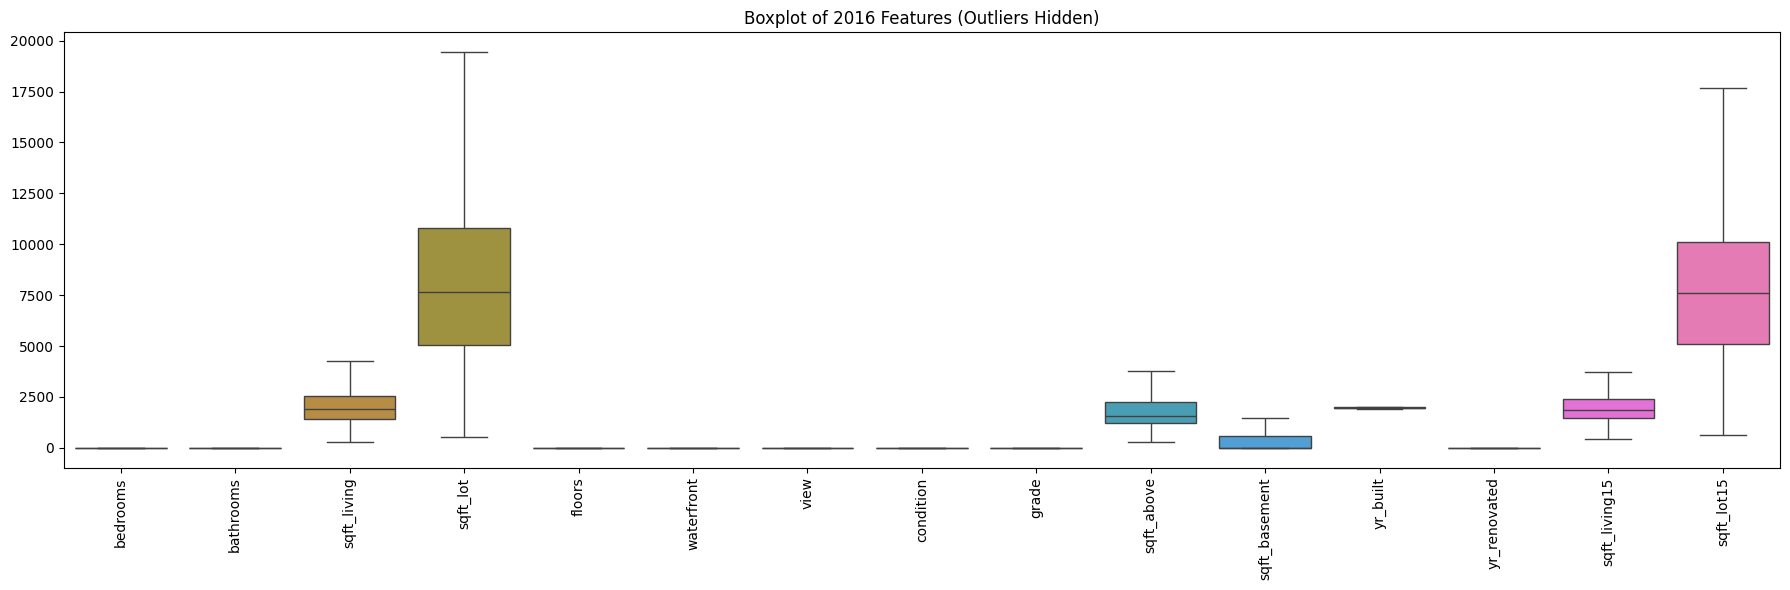

In [ ]:
# --- Visualization: boxplot for all the variables ---
print("Visualizing boxplot of all features (2016)...")
plt.figure(figsize=(18, 6))
sns.boxplot(data=data14, showfliers=False) # showfliers=False similar to outline=FALSE
plt.xticks(rotation=90)
plt.title("Boxplot of 2016 Features (Outliers Hidden)")
plt.tight_layout()
plt.show()

Matriz de correlação em 2014

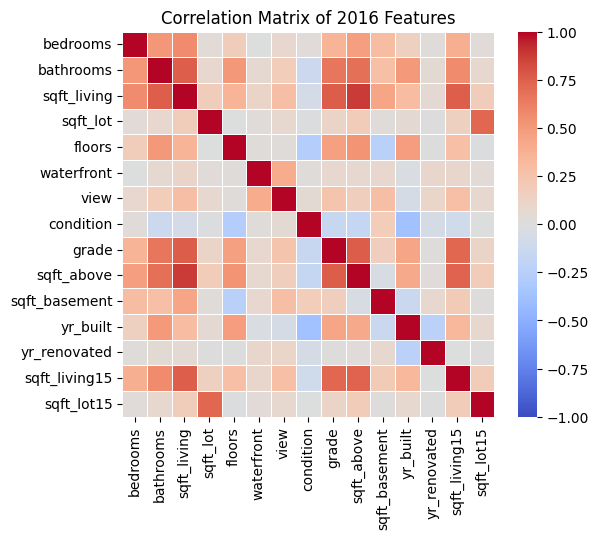

In [ ]:
corr_matrix14 = data14.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix14, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".1f", linewidths=.5) # annot=False for speed like corrplot
plt.title("Correlation Matrix of 2016 Features")
plt.show()

# Entendendo codigo

In [ ]:
# cutoff: limite acima do qual as colunas serao excluidas
cutoff = 0.7
#matriz de correlacao
df_corr = data14.corr()

highly_correlated_final = set()
corr_matrix_abs = df_corr.abs()
#monta mariz triangular
corr_matrix_upper_abs = corr_matrix_abs.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
corr_matrix_upper_abs

price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price            NaN  0.307914   0.531595     0.712431  0.084700  0.262530   
bedrooms         NaN       NaN   0.511316     0.568988  0.032237  0.175028   
bathrooms        NaN       NaN        NaN     0.752730  0.083346  0.501092   
sqft_living      NaN       NaN        NaN          NaN  0.178482  0.354969   
sqft_lot         NaN       NaN        NaN          NaN       NaN  0.003079   
floors           NaN       NaN        NaN          NaN       NaN       NaN   
waterfront       NaN       NaN        NaN          NaN       NaN       NaN   
view             NaN       NaN        NaN          NaN       NaN       NaN   
condition        NaN       NaN        NaN          NaN       NaN       NaN   
grade            NaN       NaN        NaN          NaN       NaN       NaN   
sqft_above       NaN       NaN        NaN          NaN       NaN       NaN   
sqft_basement    NaN       NaN        NaN          NaN       NaN       NaN   
yr_built         NaN       NaN        NaN          NaN       NaN       NaN   
yr_renovated     NaN       NaN        NaN          NaN       NaN       NaN   
zipcode          NaN       NaN        NaN          NaN       NaN       NaN   
lat              NaN       NaN        NaN          NaN       NaN       NaN   
long             NaN       NaN        NaN          NaN       NaN       NaN   
sqft_living15    NaN       NaN        NaN          NaN       NaN       NaN   
sqft_lot15       NaN       NaN        NaN          NaN       NaN       NaN   
year             NaN       NaN        NaN          NaN       NaN       NaN   

               waterfront      view  condition     grade  sqft_above  \
price            0.272797  0.398904   0.040841  0.670163    0.616306   
bedrooms         0.003295  0.079449   0.029054  0.353937    0.471832   
bathrooms        0.064778  0.185158   0.126487  0.662438    0.683456   
sqft_living      0.110288  0.289373   0.062619  0.761956    0.876224   
sqft_lot         0.029487  0.078023   0.010134  0.114398    0.189122   
floors           0.017543  0.021255   0.269432  0.462286    0.525481   
waterfront            NaN  0.403544   0.017535  0.081996    0.076624   
view                  NaN       NaN   0.052079  0.254747    0.164762   
condition             NaN       NaN        NaN  0.149567    0.166810   
grade                 NaN       NaN        NaN       NaN    0.758289   
sqft_above            NaN       NaN        NaN       NaN         NaN   
sqft_basement         NaN       NaN        NaN       NaN         NaN   
yr_built              NaN       NaN        NaN       NaN         NaN   
yr_renovated          NaN       NaN        NaN       NaN         NaN   
zipcode               NaN       NaN        NaN       NaN         NaN   
lat                   NaN       NaN        NaN       NaN         NaN   
long                  NaN       NaN        NaN       NaN         NaN   
sqft_living15         NaN       NaN        NaN       NaN         NaN   
sqft_lot15            NaN       NaN        NaN       NaN         NaN   
year                  NaN       NaN        NaN       NaN         NaN   

               sqft_basement  yr_built  yr_renovated   zipcode       lat  \
price               0.329027  0.050604      0.134014  0.052022  0.297503   
bedrooms            0.300744  0.151314      0.017112  0.151141  0.012284   
bathrooms           0.287505  0.496734      0.050484  0.202583  0.031384   
sqft_living         0.441072  0.309392      0.059979  0.195609  0.055294   
sqft_lot            0.017764  0.057586      0.007544  0.139330  0.094535   
floors              0.242811  0.481562      0.006884  0.060387  0.051061   
waterfront          0.085916  0.023736      0.088407  0.035380  0.019878   
view                0.292999  0.055067      0.104142  0.086635  0.003664   
condition           0.180854  0.381309      0.062042  0.016403  0.002838   
grade               0.167265  0.439306      0.014694  0.184818  0.115760   
sqft_above          0.04601

1o ciclo

In [ ]:
# max_corr -> maior correlacao dentro da matriz
max_corr = corr_matrix_upper_abs.max().max()

# Find the pair with this highest correlation
row_idx, col_idx = np.where(corr_matrix_upper_abs == max_corr)
col1 = corr_matrix_upper_abs.index[row_idx[0]]
col2 = corr_matrix_upper_abs.columns[col_idx[0]]

col1, col2,max_corr

('sqft_living', 'sqft_above', 0.8762238475456148)

In [ ]:
# Dentro do par escolhe a que tem amior correlacao com as demais, colocando em 'highly_correlated_final'
mean_abs_corr1 = corr_matrix_abs[col1].mean()
mean_abs_corr2 = corr_matrix_abs[col2].mean()

# Add the column with the higher mean absolute correlation to the set to remove
if mean_abs_corr1 > mean_abs_corr2:
    col_to_remove = col1
else:
    col_to_remove = col2 # If equal, remove the second one
highly_correlated_final.add(col_to_remove)

col_to_remove

'sqft_living'

In [ ]:
# seta pra 0 a linha e coluna da feature escolhida
corr_matrix_upper_abs.loc[col_to_remove, :] = 0
corr_matrix_upper_abs.loc[:, col_to_remove] = 0
corr_matrix_upper_abs

price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price            NaN  0.307914   0.531595          0.0  0.084700  0.262530   
bedrooms         NaN       NaN   0.511316          0.0  0.032237  0.175028   
bathrooms        NaN       NaN        NaN          0.0  0.083346  0.501092   
sqft_living      0.0  0.000000   0.000000          0.0  0.000000  0.000000   
sqft_lot         NaN       NaN        NaN          0.0       NaN  0.003079   
floors           NaN       NaN        NaN          0.0       NaN       NaN   
waterfront       NaN       NaN        NaN          0.0       NaN       NaN   
view             NaN       NaN        NaN          0.0       NaN       NaN   
condition        NaN       NaN        NaN          0.0       NaN       NaN   
grade            NaN       NaN        NaN          0.0       NaN       NaN   
sqft_above       NaN       NaN        NaN          0.0       NaN       NaN   
sqft_basement    NaN       NaN        NaN          0.0       NaN       NaN   
yr_built         NaN       NaN        NaN          0.0       NaN       NaN   
yr_renovated     NaN       NaN        NaN          0.0       NaN       NaN   
zipcode          NaN       NaN        NaN          0.0       NaN       NaN   
lat              NaN       NaN        NaN          0.0       NaN       NaN   
long             NaN       NaN        NaN          0.0       NaN       NaN   
sqft_living15    NaN       NaN        NaN          0.0       NaN       NaN   
sqft_lot15       NaN       NaN        NaN          0.0       NaN       NaN   
year             NaN       NaN        NaN          0.0       NaN       NaN   

               waterfront      view  condition     grade  sqft_above  \
price            0.272797  0.398904   0.040841  0.670163    0.616306   
bedrooms         0.003295  0.079449   0.029054  0.353937    0.471832   
bathrooms        0.064778  0.185158   0.126487  0.662438    0.683456   
sqft_living      0.000000  0.000000   0.000000  0.000000    0.000000   
sqft_lot         0.029487  0.078023   0.010134  0.114398    0.189122   
floors           0.017543  0.021255   0.269432  0.462286    0.525481   
waterfront            NaN  0.403544   0.017535  0.081996    0.076624   
view                  NaN       NaN   0.052079  0.254747    0.164762   
condition             NaN       NaN        NaN  0.149567    0.166810   
grade                 NaN       NaN        NaN       NaN    0.758289   
sqft_above            NaN       NaN        NaN       NaN         NaN   
sqft_basement         NaN       NaN        NaN       NaN         NaN   
yr_built              NaN       NaN        NaN       NaN         NaN   
yr_renovated          NaN       NaN        NaN       NaN         NaN   
zipcode               NaN       NaN        NaN       NaN         NaN   
lat                   NaN       NaN        NaN       NaN         NaN   
long                  NaN       NaN        NaN       NaN         NaN   
sqft_living15         NaN       NaN        NaN       NaN         NaN   
sqft_lot15            NaN       NaN        NaN       NaN         NaN   
year                  NaN       NaN        NaN       NaN         NaN   

               sqft_basement  yr_built  yr_renovated   zipcode       lat  \
price               0.329027  0.050604      0.134014  0.052022  0.297503   
bedrooms            0.300744  0.151314      0.017112  0.151141  0.012284   
bathrooms           0.287505  0.496734      0.050484  0.202583  0.031384   
sqft_living         0.000000  0.000000      0.000000  0.000000  0.000000   
sqft_lot            0.017764  0.057586      0.007544  0.139330  0.094535   
floors              0.242811  0.481562      0.006884  0.060387  0.051061   
waterfront          0.085916  0.023736      0.088407  0.035380  0.019878   
view                0.292999  0.055067      0.104142  0.086635  0.003664   
condition           0.180854  0.381309      0.062042  0.016403  0.002838   
grade               0.167265  0.439306      0.014694  0.184818  0.115760   
sqft_above          0.04601

2o ciclo

In [ ]:
# max_corr -> maior correlacao dentro da matriz
max_corr = corr_matrix_upper_abs.max().max()

# Find the pair with this highest correlation
row_idx, col_idx = np.where(corr_matrix_upper_abs == max_corr)
col1 = corr_matrix_upper_abs.index[row_idx[0]]
col2 = corr_matrix_upper_abs.columns[col_idx[0]]

col1, col2,max_corr

('grade', 'sqft_above', 0.7582893885251866)

In [ ]:
# Dentro do par escolhe a que tem amior correlacao com as demais, colocando em 'highly_correlated_final'
mean_abs_corr1 = corr_matrix_abs[col1].mean()
mean_abs_corr2 = corr_matrix_abs[col2].mean()

# Add the column with the higher mean absolute correlation to the set to remove
if mean_abs_corr1 > mean_abs_corr2:
    col_to_remove = col1
else:
    col_to_remove = col2 # If equal, remove the second one
highly_correlated_final.add(col_to_remove)

col_to_remove

'sqft_above'

In [ ]:
# seta pra 0 a linha e coluna da feature escolhida
corr_matrix_upper_abs.loc[col_to_remove, :] = 0
corr_matrix_upper_abs.loc[:, col_to_remove] = 0
corr_matrix_upper_abs

price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price            NaN  0.307914   0.531595          0.0  0.084700  0.262530   
bedrooms         NaN       NaN   0.511316          0.0  0.032237  0.175028   
bathrooms        NaN       NaN        NaN          0.0  0.083346  0.501092   
sqft_living      0.0  0.000000   0.000000          0.0  0.000000  0.000000   
sqft_lot         NaN       NaN        NaN          0.0       NaN  0.003079   
floors           NaN       NaN        NaN          0.0       NaN       NaN   
waterfront       NaN       NaN        NaN          0.0       NaN       NaN   
view             NaN       NaN        NaN          0.0       NaN       NaN   
condition        NaN       NaN        NaN          0.0       NaN       NaN   
grade            NaN       NaN        NaN          0.0       NaN       NaN   
sqft_above       0.0  0.000000   0.000000          0.0  0.000000  0.000000   
sqft_basement    NaN       NaN        NaN          0.0       NaN       NaN   
yr_built         NaN       NaN        NaN          0.0       NaN       NaN   
yr_renovated     NaN       NaN        NaN          0.0       NaN       NaN   
zipcode          NaN       NaN        NaN          0.0       NaN       NaN   
lat              NaN       NaN        NaN          0.0       NaN       NaN   
long             NaN       NaN        NaN          0.0       NaN       NaN   
sqft_living15    NaN       NaN        NaN          0.0       NaN       NaN   
sqft_lot15       NaN       NaN        NaN          0.0       NaN       NaN   
year             NaN       NaN        NaN          0.0       NaN       NaN   

               waterfront      view  condition     grade  sqft_above  \
price            0.272797  0.398904   0.040841  0.670163         0.0   
bedrooms         0.003295  0.079449   0.029054  0.353937         0.0   
bathrooms        0.064778  0.185158   0.126487  0.662438         0.0   
sqft_living      0.000000  0.000000   0.000000  0.000000         0.0   
sqft_lot         0.029487  0.078023   0.010134  0.114398         0.0   
floors           0.017543  0.021255   0.269432  0.462286         0.0   
waterfront            NaN  0.403544   0.017535  0.081996         0.0   
view                  NaN       NaN   0.052079  0.254747         0.0   
condition             NaN       NaN        NaN  0.149567         0.0   
grade                 NaN       NaN        NaN       NaN         0.0   
sqft_above       0.000000  0.000000   0.000000  0.000000         0.0   
sqft_basement         NaN       NaN        NaN       NaN         0.0   
yr_built              NaN       NaN        NaN       NaN         0.0   
yr_renovated          NaN       NaN        NaN       NaN         0.0   
zipcode               NaN       NaN        NaN       NaN         0.0   
lat                   NaN       NaN        NaN       NaN         0.0   
long                  NaN       NaN        NaN       NaN         0.0   
sqft_living15         NaN       NaN        NaN       NaN         0.0   
sqft_lot15            NaN       NaN        NaN       NaN         0.0   
year                  NaN       NaN        NaN       NaN         0.0   

               sqft_basement  yr_built  yr_renovated   zipcode       lat  \
price               0.329027  0.050604      0.134014  0.052022  0.297503   
bedrooms            0.300744  0.151314      0.017112  0.151141  0.012284   
bathrooms           0.287505  0.496734      0.050484  0.202583  0.031384   
sqft_living         0.000000  0.000000      0.000000  0.000000  0.000000   
sqft_lot            0.017764  0.057586      0.007544  0.139330  0.094535   
floors              0.242811  0.481562      0.006884  0.060387  0.051061   
waterfront          0.085916  0.023736      0.088407  0.035380  0.019878   
view                0.292999  0.055067      0.104142  0.086635  0.003664   
condition           0.180854  0.381309      0.062042  0.016403  0.002838   
grade               0.167265  0.439306      0.014694  0.184818  0.115760   
sqft_above          0.00000

In [ ]:
# executa as outra colunas ate não achar nunhma correlaçao que es=xtraooel o cutoff
max_corr = corr_matrix_upper_abs.max().max()
if max_corr < cutoff:
    break # No more correlations above cutoff

# Excluindo features altamente relacionadas

Finding highly correlated features (cutoff=0.9)...
Columns to drop due to high correlation: ['sqft_living']
Data 2016 shape after removing correlated features: (14633, 14)
Data 2017 shape after removing correlated features: (6980, 14)
Visualizing correlation matrix after removing highly correlated features...


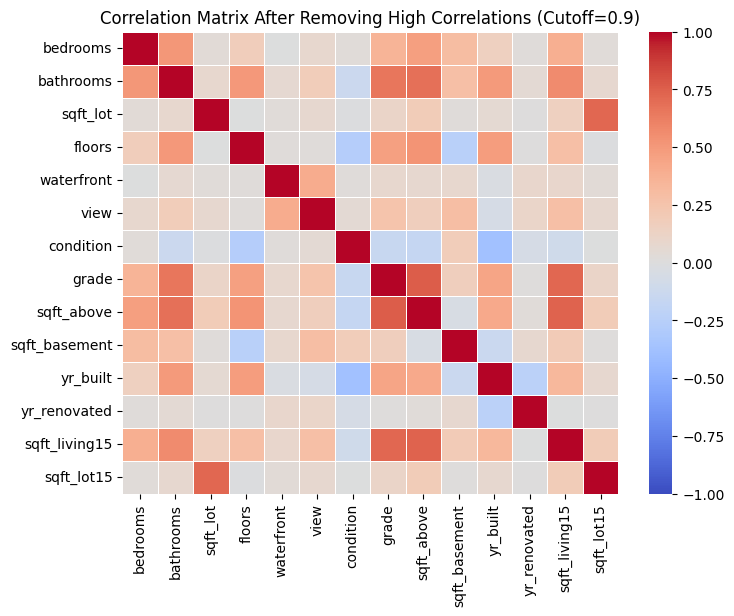

In [ ]:
# --- Removal of highly correlated feature pairs (keeping only one element of the pair) ---
#  data14_reduced, data15_reduced

def find_correlation(df_corr, cutoff=0.9):
    """
    Finds highly correlated features based on a cutoff.
    Returns a list of column names to potentially remove.
    It identifies pairs above the cutoff and flags the column with the higher
    mean absolute correlation across all other columns.
    """
    highly_correlated = set()
    # Ensure the matrix is symmetric and avoid self-correlation
    corr_matrix_upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

    for col in corr_matrix_upper.columns:
        if col in highly_correlated:
            continue
        correlated_cols = corr_matrix_upper.index[abs(corr_matrix_upper[col]) > cutoff].tolist()
        if correlated_cols:
            # Add the current column and its correlated partners to a potential removal list
            cols_to_compare = [col] + correlated_cols
            mean_abs_corr = df_corr.loc[cols_to_compare, cols_to_compare].abs().mean()
            # Flag the column with the highest mean absolute correlation (excluding itself)
            col_to_remove = mean_abs_corr.idxmax()
            highly_correlated.add(col_to_remove)
            # Flag the others involved in this specific high-corr check as well, but prioritize the one flagged above
            for c in cols_to_compare:
                 if c != col_to_remove:
                     # Only add if not already flagged by a *different* check resulting in higher mean corr
                     # This logic is simplified compared to caret but captures the essence.
                     # A more robust version might re-evaluate mean correlations after each removal.
                     highly_correlated.add(c)
            # Refined logic: From the identified group, remove the one with highest mean abs corr
            # Let's try removing just one per group initially - the one with highest mean corr
            cols_to_compare = [col] + correlated_cols
            mean_abs_corr = df_corr[cols_to_compare].abs().mean() # Mean abs corr with *all* features
            col_to_remove = mean_abs_corr.idxmax()
            highly_correlated.add(col_to_remove)
            # Remove the other columns found in this specific check temporarily to avoid redundant checks
            for c in correlated_cols:
                 corr_matrix_upper[c] = 0 # Zero out column to avoid re-checking


    # Correcting the logic: caret finds pairs > cutoff, then removes the one with higher mean abs corr.
    highly_correlated_final = set()
    corr_matrix_abs = df_corr.abs()
    corr_matrix_upper_abs = corr_matrix_abs.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

    while True:
        # Find the highest correlation exceeding the cutoff
        max_corr = corr_matrix_upper_abs.max().max()
        if max_corr < cutoff:
            break # No more correlations above cutoff

        # Find the pair with this highest correlation
        row_idx, col_idx = np.where(corr_matrix_upper_abs == max_corr)
        # Get the actual column names (handle potential multiple pairs with same max corr)
        col1 = corr_matrix_upper_abs.index[row_idx[0]]
        col2 = corr_matrix_upper_abs.columns[col_idx[0]]

        # Calculate mean absolute correlation for each column in the pair
        mean_abs_corr1 = corr_matrix_abs[col1].mean()
        mean_abs_corr2 = corr_matrix_abs[col2].mean()

        # Add the column with the higher mean absolute correlation to the set to remove
        if mean_abs_corr1 > mean_abs_corr2:
            col_to_remove = col1
        else:
            col_to_remove = col2 # If equal, remove the second one

        highly_correlated_final.add(col_to_remove)

        # Remove the flagged column from consideration by setting its correlations to 0
        corr_matrix_upper_abs.loc[col_to_remove, :] = 0
        corr_matrix_upper_abs.loc[:, col_to_remove] = 0

    return list(highly_correlated_final)

corr_matrix14 = data14.corr()
corr_matrix15 = data15.corr()

print("Finding highly correlated features (cutoff=0.9)...")
cols_to_drop = find_correlation(corr_matrix14, cutoff=0.8)
print(f"Columns to drop due to high correlation: {cols_to_drop}")

data14_reduced = data14.drop(columns=cols_to_drop)
data15_reduced = data15.drop(columns=cols_to_drop)

print(f"Data 2016 shape after removing correlated features: {data14_reduced.shape}")
print(f"Data 2017 shape after removing correlated features: {data15_reduced.shape}")

print("Visualizing correlation matrix after removing highly correlated features...")
corr_matrix16_reduced = data14_reduced.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix16_reduced, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".1f", linewidths=.5)
plt.title("Correlation Matrix After Removing High Correlations (Cutoff=0.9)")
plt.show()

# Assigning target labels

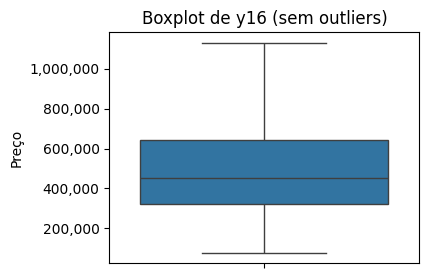

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(4, 3))
sns.boxplot(data=y14, showfliers=False)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.ylabel('Preço')
plt.title('Boxplot de y16 (sem outliers)')
plt.show()

Cria variavel categorica para indicar se está  nos 20% maiores: y14_factor e y15_factor pra separar

In [ ]:
# criar um fator que vale 1 se o valor não estiver no top 20% e 2 se estiver no top 20%.
# Isso permite criar uma variavel Categorica

cutoff = y14.quantile(0.8)
y14_factor = (y14 > cutoff).astype(int) + 1

print("\nClass distribution for 2014 (1 if not in top quintile, 2 if in top quintile):")
counts_14 = y14_factor.value_counts().sort_index()
# Check if both classes exist before printing (handles cases where data might be skewed)
if 1 not in counts_14: counts_14[1] = 0
if 2 not in counts_14: counts_14[2] = 0
counts_14 = counts_14.sort_index() # Ensure order after potentially adding keys
for index, value in counts_14.items():
    print(f"{index}    {value}")

print("\n")
print("*" * 100)
print("\n")

########## 2015 ************
cutoff = y14.quantile(0.8)
y15_factor = (y15 > cutoff).astype(int) + 1

print("\nClass distribution for 2015 (1 if not in top quintile, 2 if in top quintile):")
counts_15 = y15_factor.value_counts().sort_index()
# Check if both classes exist before printing (handles cases where data might be skewed)
if 1 not in counts_15: counts_15[1] = 0
if 2 not in counts_15: counts_15[2] = 0
counts_15 = counts_15.sort_index() # Ensure order after potentially adding keys
for index, value in counts_15.items():
    print(f"{index}    {value}")

print("\n")
print("*" * 100)
print("\n")


Class distribution for 2014 (1 if not in top quintile, 2 if in top quintile):
1    11723
2    2910


****************************************************************************************************



Class distribution for 2015 (1 if not in top quintile, 2 if in top quintile):
1    5616
2    1364


****************************************************************************************************




#Train/test split

Escalonamento

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled = scaler.fit_transform(data14_reduced)
#converte p/ dataframe
data14_scaled = pd.DataFrame(scaled, index=data14_reduced.index, columns=data14_reduced.columns)

scaled = scaler.fit_transform(data15_reduced)
#converte p/ dataframe
data15_scaled = pd.DataFrame(scaled, index=data15_reduced.index, columns=data15_reduced.columns)

X_train e Y_Train serão os dados de 2014

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test_14, y_train, y_test_14 = train_test_split(
    data14_scaled,
    y14_factor,
    test_size=.25,
    random_state=0)

print(f"Training set shape: {X_train.shape}")
print(f"Test set 2014 shape: {X_test_14.shape}")

X_train, X_test_15, y_train, y_test_15 = train_test_split(
    data15_scaled,
    y15_factor,
    test_size=.25,
    random_state=0)

print(f"Training set shape: {X_train.shape}")
print(f"Test set 2014 shape: {X_test_14.shape}")

Training set shape: (10974, 14)
Test set 2014 shape: (3659, 14)
Training set shape: (5235, 14)
Test set 2014 shape: (3659, 14)


# Arvore de Decisao

<h3>Faz cross-validation para encontrar media de Accuracy</h3>

Ajuda a diagnosticar overfitting — se o erro de treino (TR Error) for muito menor que o de validação (VA Error), a árvore está sobreajustada.

Bom ajuste: Acurácias altas e próximas (diferença até ~5 p.p.).
Ex.: Treino 0.88, Teste 0.85

Overfitting: Treino muito maior que teste (diferença > 10 p.p.).
Ex.: Treino 0.99, Teste 0.70

Underfitting: Ambas baixas e próximas → modelo fraco.
Ex.: Treino 0.65, Teste 0.63<

In [ ]:
# --- Cross-Validation Setup ---
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

# --- Single Tree ---
cv_results_tree = {'fold': [], 'Acc_treino': [], 'Acc_teste': [],'diff_pct': []}
fold_counter = 1

for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # treina o modelo Arvore de Decisao
    my_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    my_tree.fit(X_cv_train, y_cv_train)

    # calacula as prediçoes para treino e teste
    pred_train = my_tree.predict(X_cv_train)
    pred_val = my_tree.predict(X_cv_val)


    cv_results_tree['fold'].append(fold_counter)


    # calcula acurracy do treino
    acuracia_treino = accuracy_score(y_cv_train, pred_train)
    cv_results_tree['Acc_treino'].append(acuracia_treino)

    # calcula acurracy do teste
    acuracia_teste =  accuracy_score(y_cv_val, pred_val)
    cv_results_tree['Acc_teste'].append(acuracia_teste)

    diff_pct = abs(acuracia_treino - acuracia_teste) / acuracia_treino * 100 if acuracia_treino!=0 else 0
    cv_results_tree['diff_pct'].append(diff_pct)

    fold_counter += 1

cv_results_tree_df = pd.DataFrame(cv_results_tree)
print("CV Results (Single Tree):")
print(cv_results_tree_df)
mean_acuracia_teste = cv_results_tree_df['Acc_teste'].mean()
print(f"\nMean Accuracy Teste (Single Tree): {mean_acuracia_teste:.4f}")

CV Results (Single Tree):
   fold  Acc_treino  Acc_teste   diff_pct
0     1    1.000000   0.859745  14.025501
1     2    0.999797   0.867031  13.279342
2     3    0.999797   0.872495  12.732783
3     4    0.999797   0.869763  13.006062
4     5    0.999899   0.862352  13.756081
5     6    0.999798   0.868733  13.109115
6     7    0.999798   0.841386  15.844400
7     8    0.999798   0.870556  12.926762
8     9    0.999798   0.866910  13.291467
9    10    0.999899   0.863263  13.664914

Mean Accuracy Teste (Single Tree): 0.8642


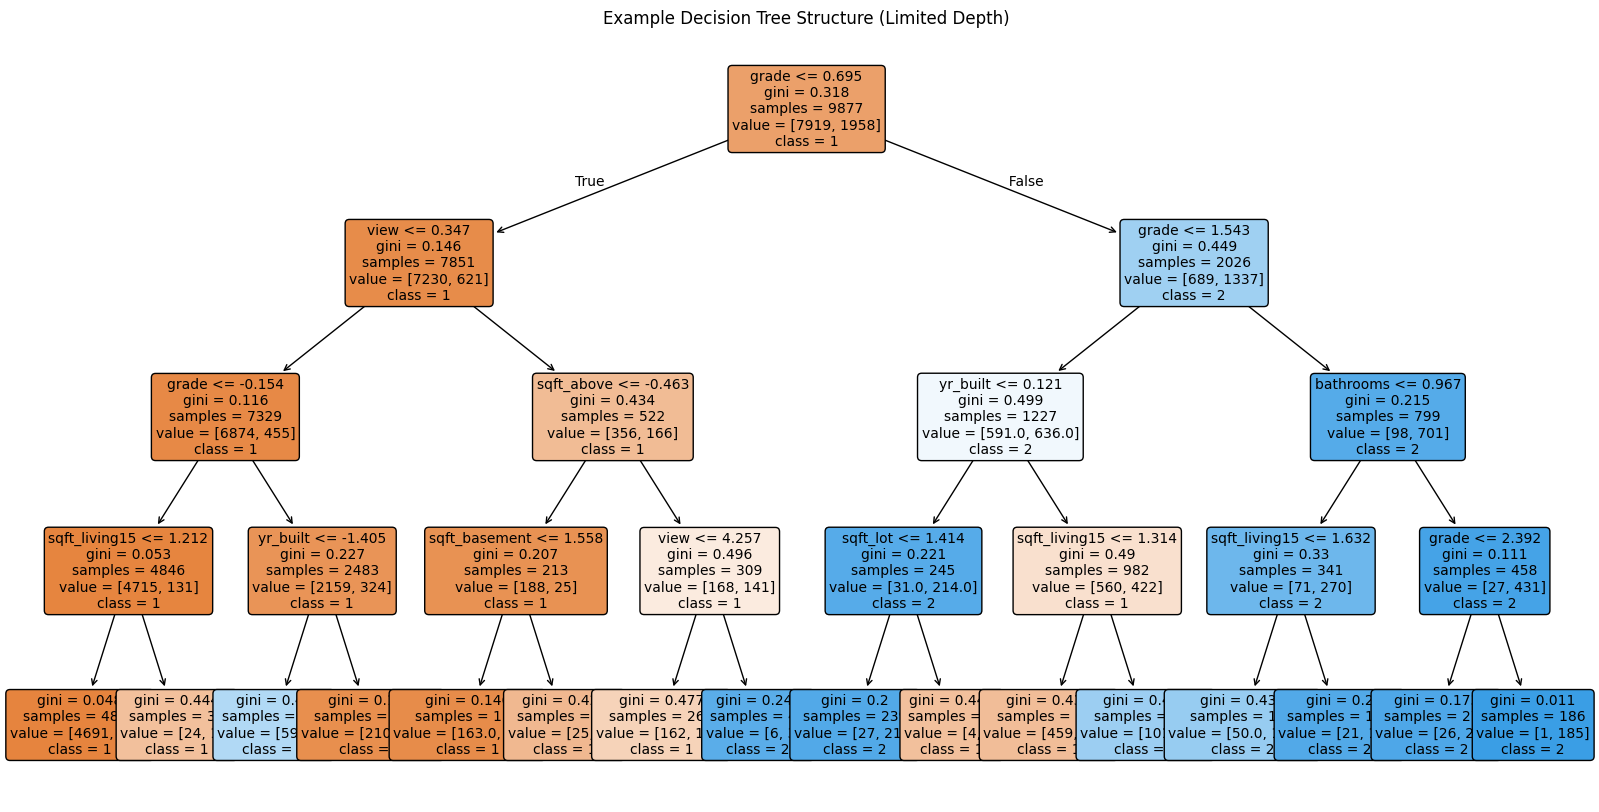

In [ ]:
# --- Single Tree model visualization ---
feature_names = X_train.columns.tolist()
class_names = [str(c) for c in sorted(y_train.unique())] # ['1', '2']

last_train_idx, last_val_idx = list(cv.split(X_train, y_train))[-1]
X_last_cv_train, y_last_cv_train = X_train.iloc[last_train_idx], y_train.iloc[last_train_idx]
final_tree_viz = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4) # Limit depth for viz
final_tree_viz.fit(X_last_cv_train, y_last_cv_train)

plt.figure(figsize=(20, 10))
plot_tree(final_tree_viz,
          filled=True,
          rounded=True,
          feature_names=feature_names,
          class_names=class_names,
          fontsize=10)
plt.title("Example Decision Tree Structure (Limited Depth)")
plt.show()

# Random Forest

Faz cross-validation com dados de 2014, para encontrrar media de Accuracy

Tunnig p/ encontrar melhores parametros


*   n_estimators	Número de árvores na floresta	Mais árvores = modelo mais robusto, mas mais lento

*   max_depth	Profundidade máxima de cada árvore	Limita complexidade; evita overfitting se for baixo

*   min_samples_split	Mínimo de amostras necessárias para dividir um nó	Controla crescimento da árvore

*   min_samples_leaf	Mínimo de amostras em cada folha	Evita folhas muito pequenas (overfitting)

*   max_features	Número máximo de variáveis consideradas em cada divisão	Controla aleatoriedade e diversidade das árvores

*   bootstrap	Se amostras são com reposição (True) ou não	Bootstrap True = Random
Forest clássico; False = Extra Trees

*   criterion	Métrica usada para medir qualidade da divisão (ex.: 'gini', 'entropy')	Afeta a form

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


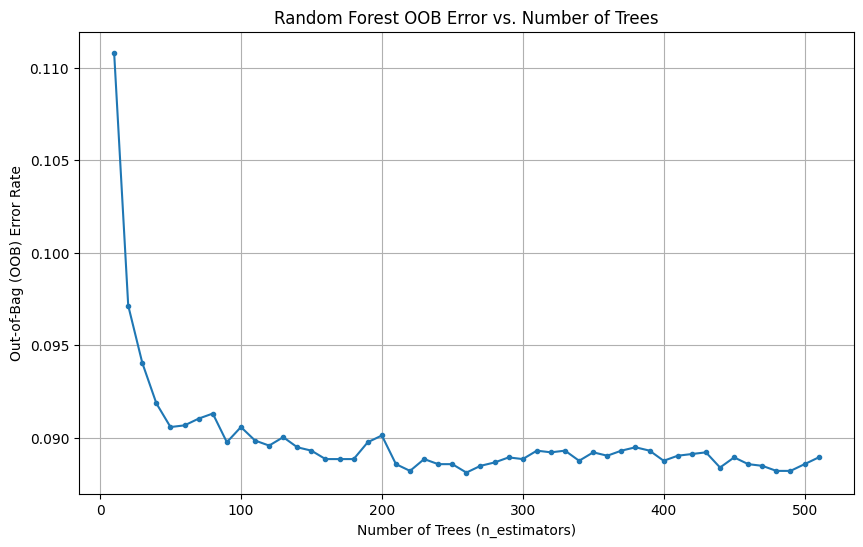

In [ ]:
# faz loop com numero de arvores de 10 ate 513
# acha o oob_score que é uma metrica de erro

rf_oob = RandomForestClassifier(n_estimators=512,
                                random_state=RANDOM_STATE,
                                oob_score=True,
                                n_jobs=-1,
                                warm_start=True)

oob_errors = []
min_estimators = 10
for n_estimators in range(min_estimators, 513, 10):
    rf_oob.set_params(n_estimators=n_estimators)
    rf_oob.fit(X_train, y_train)
    if rf_oob.oob_score_:
        oob_errors.append(1.0 - rf_oob.oob_score_)
    else:
        oob_errors.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(range(min_estimators, 513, 10), oob_errors, marker='.')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Out-of-Bag (OOB) Error Rate")
plt.title("Random Forest OOB Error vs. Number of Trees")
plt.grid(True)
plt.show()

tunning do Curso

In [ ]:
from sklearn.model_selection import GridSearchCV

parametros={'criterion':['gini','entropy'],
            'min_samples_leaf':[1,5,10],
            'min_samples_split':[2,5,10],
            'n_estimators':[10,40,100,150,200]
            }
grid=GridSearchCV(estimator=RandomForestClassifier(),param_grid=parametros)
grid.fit(X_train, y_train)
print (grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40} 0.913886827400469


Validação Cruzada com dados de 2014

Executa com n_estimator=200 (melhor para metro)

In [ ]:
# --- Getting the metrics for the final version of the Random Forest --- [TO DO]
print("\n--- Training Improved Random Forest (ntree=200, balanced) with Cross-Validation ---")

k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

cv_results_rf_imp = {'fold': [], 'TR error': [], 'TR accuracy': [],'VA error': [],'VA accuracy':[], 'Precision': [], 'Classification Rate': [], 'Recall': []}
fold_counter = 1

for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # treina o modelo
    my_rforest_imp = RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    my_rforest_imp.fit(X_cv_train, y_cv_train)

    cv_results_rf_imp['fold'].append(fold_counter)

    # usa base de treino p/ predizer
    pred_train = my_rforest_imp.predict(X_cv_train)
    tr_error = 1.0 - accuracy_score(y_cv_train, pred_train)
    tr_accuracy = accuracy_score(y_cv_train, pred_train)
    cv_results_rf_imp['TR error'].append(tr_error)
    cv_results_rf_imp['TR accuracy'].append(tr_accuracy)

    # usa base de teste p/ predizer
    pred_val = my_rforest_imp.predict(X_cv_val)
    va_error = 1.0 - accuracy_score(y_cv_val, pred_val)
    va_accuracy = accuracy_score(y_cv_val, pred_val)
    cv_results_rf_imp['VA error'].append(va_error)
    cv_results_rf_imp['VA accuracy'].append(va_accuracy)

    # Calculate metrics for the validation set
    precision = precision_score(y_cv_val, pred_val, pos_label=2, zero_division=0) # R uses 1 if NaN, sklearn uses 0
    cv_results_rf_imp['Precision'].append(precision if not np.isnan(precision) else 1.0) # NaN -> 1 for precision

    recall = recall_score(y_cv_val, pred_val, pos_label=2, zero_division=0)
    cv_results_rf_imp['Recall'].append(recall if not np.isnan(recall) else 1.0) # NaN -> 1 for recall

    # Classification rate is just accuracy in this binary case
    class_rate = accuracy_score(y_cv_val, pred_val)
    cv_results_rf_imp['Classification Rate'].append(class_rate)

    fold_counter += 1

cv_results_rf_imp_df = pd.DataFrame(cv_results_rf_imp)
print("CV Results (Improved Random Forest):")
print(cv_results_rf_imp_df)

print("\nCV Error (Mean Validation Error):")
mean_va_error_rf_imp = cv_results_rf_imp_df['VA error'].mean()
print(f"{mean_va_error_rf_imp:.4f}")

print("Precision (Mean Validation):")
mean_precision_rf_imp = cv_results_rf_imp_df['Precision'].mean()
print(f"{mean_precision_rf_imp:.4f}")

print("Classification Rate (Mean Validation Accuracy):")
mean_class_rate_rf_imp = cv_results_rf_imp_df['Classification Rate'].mean()
print(f"{mean_class_rate_rf_imp:.4f}")

print("Recall (Mean Validation):")
mean_recall_rf_imp = cv_results_rf_imp_df['Recall'].mean()
print(f"{mean_recall_rf_imp:.4f}")


--- Training Improved Random Forest (ntree=200, balanced) with Cross-Validation ---
CV Results (Improved Random Forest):
   fold  TR error  TR accuracy  VA error  VA accuracy  Precision  \
0     1  0.000000     1.000000  0.091985     0.908015   0.812834   
1     2  0.000203     0.999797  0.083789     0.916211   0.846154   
2     3  0.000203     0.999797  0.101093     0.898907   0.802260   
3     4  0.000203     0.999797  0.078324     0.921676   0.833333   
4     5  0.000101     0.999899  0.085688     0.914312   0.829787   
5     6  0.000202     0.999798  0.087511     0.912489   0.823529   
6     7  0.000202     0.999798  0.089335     0.910665   0.818182   
7     8  0.000202     0.999798  0.090246     0.909754   0.795000   
8     9  0.000202     0.999798  0.085688     0.914312   0.828877   
9    10  0.000101     0.999899  0.084777     0.915223   0.856322   

   Classification Rate    Recall  
0             0.908015  0.697248  
1             0.916211  0.706422  
2             0.898907  

testando em 2014 e 2015


In [ ]:
# --- Test Random Forest
print("\n--- Testing Final Random Forest Model on Hold-Out Sets ---")

# Train the final model on the *full* training set (X_train, y_train)
final_rforest = RandomForestClassifier(
    n_estimators =200 ,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
final_rforest.fit(X_train, y_train)

# Evaluate on 2014 Test Set (X_test_14, y_test_14)
pred_test_14 = final_rforest.predict(X_test_14)
print("\n--- 2014 Test Set Performance ---")
test_14_error = 1.0 - accuracy_score(y_test_14, pred_test_14)
test_14_precision = precision_score(y_test_14, pred_test_14, pos_label=2, zero_division=0)
test_14_recall = recall_score(y_test_14, pred_test_14, pos_label=2, zero_division=0)
test_14_class_rate = accuracy_score(y_test_14, pred_test_14)

print(f"2014 test error (1 - accuracy): {test_14_error:.4f}")
print(f"2014 test precision: {test_14_precision:.4f}")
print(f"2014 test classification rate (accuracy): {test_14_class_rate:.4f}")
print(f"2014 test recall: {test_14_recall:.4f}")

# Evaluate on 2015 Test Set (X_test_15, y_test_15)
pred_test_15 = final_rforest.predict(X_test_15)
print("\n--- 2015 Test Set Performance")
test_15_error = 1.0 - accuracy_score(y_test_15, pred_test_15)
test_15_precision = precision_score(y_test_15, pred_test_15, pos_label=2, zero_division=0)
test_15_recall = recall_score(y_test_15, pred_test_15, pos_label=2, zero_division=0)
test_15_class_rate = accuracy_score(y_test_15, pred_test_15)

print(f"2015 test error (1 - accuracy): {test_15_error:.4f}")
print(f"2015 test precision: {test_15_precision:.4f}")
print(f"2015 test classification rate (accuracy): {test_15_class_rate:.4f}")
print(f"2015 test recall: {test_15_recall:.4f}")


--- Testing Final Random Forest Model on Hold-Out Sets ---

--- 2014 Test Set Performance ---
2014 test error (1 - accuracy): 0.0913
2014 test precision: 0.8148
2014 test classification rate (accuracy): 0.9087
2014 test recall: 0.7061

--- 2015 Test Set Performance
2015 test error (1 - accuracy): 0.1054
2015 test precision: 0.7943
2015 test classification rate (accuracy): 0.8946
2015 test recall: 0.6400


Treina modelo com todos os dados do ano

In [ ]:
# --- Test Random Forest
print("\n--- Testing Final Random Forest Model on Hold-Out Sets ---")

# Train the final model on the *full* training set (X_train, y_train)
final_rforest = RandomForestClassifier(
    n_estimators =200 ,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
final_rforest.fit(data14_scaled, y14_factor)

# Evaluate on 2014 Test Set (X_test_14, y_test_14)
pred_test_14 = final_rforest.predict(X_test_14)
print("\n--- 2014 Test Set Performance ---")
test_14_error = 1.0 - accuracy_score(y_test_14, pred_test_14)
test_14_precision = precision_score(y_test_14, pred_test_14, pos_label=2, zero_division=0)
test_14_recall = recall_score(y_test_14, pred_test_14, pos_label=2, zero_division=0)
test_14_class_rate = accuracy_score(y_test_14, pred_test_14)

print(f"2014 test error (1 - accuracy): {test_14_error:.4f}")
print(f"2014 test precision: {test_14_precision:.4f}")
print(f"2014 test classification rate (accuracy): {test_14_class_rate:.4f}")
print(f"2014 test recall: {test_14_recall:.4f}")

# Evaluate on 2015 Test Set (X_test_15, y_test_15)
pred_test_15 = final_rforest.predict(X_test_15)
print("\n--- 2015 Test Set Performance")
test_15_error = 1.0 - accuracy_score(y_test_15, pred_test_15)
test_15_precision = precision_score(y_test_15, pred_test_15, pos_label=2, zero_division=0)
test_15_recall = recall_score(y_test_15, pred_test_15, pos_label=2, zero_division=0)
test_15_class_rate = accuracy_score(y_test_15, pred_test_15)

print(f"2015 test error (1 - accuracy): {test_15_error:.4f}")
print(f"2015 test precision: {test_15_precision:.4f}")
print(f"2015 test classification rate (accuracy): {test_15_class_rate:.4f}")
print(f"2015 test recall: {test_15_recall:.4f}")


--- Testing Final Random Forest Model on Hold-Out Sets ---

--- 2014 Test Set Performance ---
2014 test error (1 - accuracy): 0.0000
2014 test precision: 1.0000
2014 test classification rate (accuracy): 1.0000
2014 test recall: 1.0000

--- 2015 Test Set Performance
2015 test error (1 - accuracy): 0.1043
2015 test precision: 0.7958
2015 test classification rate (accuracy): 0.8957
2015 test recall: 0.6457


#  Backtesting


In [16]:
import yfinance as yf
import cvxpy as cp
import numpy as np
import pandas as pd

#supondo que essas sejam as escolhidas pelo modelo
ticker = ['PETR4.SA','ITSA4.SA','VALE3.SA','EGIE3.SA']
df = yf.download(ticker, start="2024-01-01", end="2025-01-01")  # período de 1 ano

#df.columns = df.columns.droplevel('Ticker')
#df = df.reset_index()
returns = df["Close"].pct_change().dropna()
n_assets = returns.shape[1]

/tmp/ipython-input-1218655974.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2024-01-01", end="2025-01-01")  # período de 1 ano
[*********************100%***********************]  4 of 4 completed


In [17]:
rebalance_freq = 21 # rebalanceamento mensal
rebalance_indices = list(range(0, len(returns), rebalance_freq))

markowitz_weights_list = []
equal_weights_list = []  # 1/N portfolio weights
rebalance_dates = []

markowitz_ret_series = pd.Series(dtype=float)
equal_ret_series = pd.Series(dtype=float)  # 1/N portfolio returns

for idx in rebalance_indices:
    if idx == 0:
        # inicializa pesos com  1/N
        w_markowitz = np.ones(n_assets) / n_assets
        w_equal = np.ones(n_assets) / n_assets
    else:
        train = returns.iloc[idx-rebalance_freq : idx]
        Sigma = train.cov()
        mu = train.mean().values

        w_var = cp.Variable(n_assets)
        # aversao ao risco
        lmbd = 5.0
        # função objetivo: max (mu^T w - λ * risco)
        objective = cp.Maximize(mu @ w_var - lmbd * cp.quad_form(w_var, Sigma))
        # restrições: soma = 1, pesos >= 0
        constraints = [cp.sum(w_var) == 1, w_var >= 0]
        # define e resolve
        prob = cp.Problem(objective, constraints)
        prob.solve()

        w_markowitz = w_var.value

        # Equally weighted portfolio (equal weights)
        w_equal = np.ones(n_assets) / n_assets

    # append na lista
    markowitz_weights_list.append(w_markowitz)
    equal_weights_list.append(w_equal)
    rebalance_dates.append(returns.index[idx])

    # markowitz_test_ret e equal_test_ret -> retorno na prox janela de 30 dias
    next_idx = idx + rebalance_freq
    test = returns.iloc[idx : next_idx]
    markowitz_test_ret = test.dot(w_markowitz)
    equal_test_ret = test.dot(w_equal)

    # append na lista
    markowitz_ret_series = pd.concat([markowitz_ret_series, markowitz_test_ret])
    equal_ret_series = pd.concat([equal_ret_series, equal_test_ret])


/tmp/ipython-input-1895944157.py:48: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  markowitz_ret_series = pd.concat([markowitz_ret_series, markowitz_test_ret])
/tmp/ipython-input-1895944157.py:49: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  equal_ret_series = pd.concat([equal_ret_series, equal_test_ret])


In [19]:
equal_ret_series

2024-01-03    0.005906
2024-01-04   -0.009409
2024-01-05    0.002221
2024-01-08   -0.006661
2024-01-09   -0.002375
                ...   
2024-12-20    0.009199
2024-12-23   -0.010390
2024-12-26    0.005169
2024-12-27   -0.008389
2024-12-30    0.006782
Length: 250, dtype: float64